In [48]:
import torch
import torchvision
import time
import copy
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [2]:
print('Torchvision Version:', torchvision.__version__)

Torchvision Version: 0.2.2


In [91]:
# 数据
data_dir = './hymenoptera_data'
model_name = 'resnet'
num_classes = 2
batch_size = 32
num_epochs = 20
feature_extract = True
input_size = 224
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 查看数据

In [4]:
# 读入数据
all_imgs = datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    transforms.Compose([
        transforms.RandomResizedCrop(input_size),  # 把每张图片变成resnet需要输入的维度224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]))
loader = DataLoader(all_imgs, batch_size=batch_size, shuffle=True)

In [8]:
img = next(iter(dataloaders_dict['valid']))[0]

In [9]:
print(img.shape)

torch.Size([32, 3, 224, 224])


In [10]:
uploader = transforms.ToPILImage()  # 把Tensor或数组转化为图像
plt.ion()

In [16]:
def im_show(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = uploader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(1)

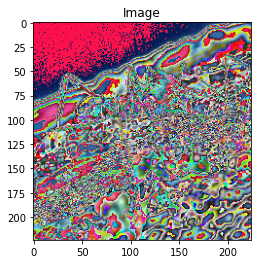

In [17]:
plt.figure()
im_show(tensor=img[8], title='Image')

# batch迭代

In [18]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [19]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'valid']
}

In [20]:
dataloaders_dict = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'valid']
}

In [21]:
inputs, labels = next(iter(dataloaders_dict['train']))  # 一个batch
print(inputs.shape)
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0])


In [22]:
for inputs, labels in dataloaders_dict['train']:
    print(labels.size())

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([20])


# 加载ResNet模型并修改全连接层

In [23]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Number of epochs to train for
num_epochs = 5
# Flag for feature extracting. When False, we finetune the whole model, when True we only update the reshaped layer params.
feature_extract = True  # 只更新修改的层

In [30]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [31]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == 'resnet':
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model=model_ft, feature_extracting=feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)  # out_features=100 change to num_classes=2
        input_size = 224
    return model_ft, input_size

In [32]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [33]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [44]:
# 全连接层输入特征的维度

In [43]:
num_ftrs = model_ft.fc.in_features
num_ftrs

512

# 查看需要更新的参数，定义优化器

In [34]:
next(iter(model_ft.named_parameters()))

('conv1.weight',
 Parameter containing:
 tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
             1.7083e-02, -1.2694e-02],
           [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
            -1.2907e-01,  3.7424e-03],
           [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
             2.5632e-01,  6.3573e-02],
           ...,
           [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
            -4.2058e-01, -2.5781e-01],
           [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
             3.9359e-01,  1.6606e-01],
           [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
            -8.2230e-02, -5.7828e-03]],
 
          [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
             6.6221e-04, -2.5743e-02],
           [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
            -1.6051e-01, -1.2826e-03],
           [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,

In [36]:
len(next(iter(model_ft.named_parameters())))  # 是元组，只有两个值

2

In [45]:
# 查看都有哪些参数

In [37]:
for name, param in model_ft.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [38]:
# Seed the model to GPU

In [49]:
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()  # 需要更新的参数
print('Params to learn:')
if feature_extract:
    params_to_update = []  # 需要更新的参数存放于此
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:  # fc层之前层param.requires_grad==False, 后面加的fc层为True
            params_to_update.append(param)
            print('\t', name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print('\t', name)
optimizer_ft = optim.SGD(params=params_to_update, lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

Params to learn:
	 fc.weight
	 fc.bias


# 定义训练模型

In [65]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())  # 深拷贝上面的resnet模型参数
    best_acc = 0.
    for epoch in range(num_epochs):
        print(f'Epoch {epoch} / {num_epochs - 1}')
        print('--' * 10)
        for phase in ['train', 'valid']:
            running_loss = 0.
            running_corrects = 0.
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.autograd.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)  # 返回每一行最大的数和索引，preds的位置是索引的位置
                # or _, preds = outputs.argmax(dim=1)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)  # 交叉熵损失函数是平均过的
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()  # view(-1)展开到一维并自己计算
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            print(f'Phase: {phase}, Loss: {epoch_loss}, Acc: {epoch_acc}')
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())  # 模型变好就深拷贝更新后的模型参数
            if phase == 'valid':
                val_acc_history.append(epoch_acc)  # 记录每个epoch验证集的准确率
    time_elapsed = time.time() - since  # 注意缩进
    print('Training compete in {}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {}'.format(best_acc))
    model.load_state_dict(best_model_wts)  # 把最新的参数复制到model中
    return model, val_acc_history

# 训练

In [67]:
model_ft, val_acc_history = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=20)

Epoch 0 / 19
--------------------
Phase: train, Loss: 0.17671104264063914, Acc: 0.9426229508196722
Phase: valid, Loss: 0.20428448506430083, Acc: 0.9477124183006536
Epoch 1 / 19
--------------------
Phase: train, Loss: 0.13449813181259593, Acc: 0.9590163934426229
Phase: valid, Loss: 0.19666170131634264, Acc: 0.9477124183006536
Epoch 2 / 19
--------------------
Phase: train, Loss: 0.1966762076147267, Acc: 0.9057377049180327
Phase: valid, Loss: 0.20206324512662452, Acc: 0.934640522875817
Epoch 3 / 19
--------------------
Phase: train, Loss: 0.16145966287519112, Acc: 0.9426229508196722
Phase: valid, Loss: 0.21801250763967925, Acc: 0.9215686274509803
Epoch 4 / 19
--------------------
Phase: train, Loss: 0.1655642849500062, Acc: 0.9221311475409836
Phase: valid, Loss: 0.19926903469889773, Acc: 0.934640522875817
Epoch 5 / 19
--------------------
Phase: train, Loss: 0.16032381575615678, Acc: 0.9385245901639344
Phase: valid, Loss: 0.19727758858718125, Acc: 0.934640522875817
Epoch 6 / 19
--------

In [68]:
val_acc_history

[0.9477124183006536,
 0.9477124183006536,
 0.934640522875817,
 0.9215686274509803,
 0.934640522875817,
 0.934640522875817,
 0.934640522875817,
 0.9607843137254902,
 0.934640522875817,
 0.9281045751633987,
 0.934640522875817,
 0.934640522875817,
 0.934640522875817,
 0.9411764705882353,
 0.934640522875817,
 0.9019607843137255,
 0.9477124183006536,
 0.8888888888888888,
 0.954248366013072,
 0.934640522875817]

In [69]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [70]:
# Initialize the non-pretrained version of the model used for this run

In [71]:
# 所有参数都训练，不要ImageNet的参数

In [73]:
scratch_model, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(params=scratch_model.parameters(), lr=0.01, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_, scratch_history = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=20)

Epoch 0 / 19
--------------------
Phase: train, Loss: 0.6837459665830018, Acc: 0.5778688524590164
Phase: valid, Loss: 0.7563023913919537, Acc: 0.5424836601307189
Epoch 1 / 19
--------------------
Phase: train, Loss: 0.7088132735158577, Acc: 0.5819672131147541
Phase: valid, Loss: 0.7710584141070547, Acc: 0.6339869281045751
Epoch 2 / 19
--------------------
Phase: train, Loss: 0.7900061822328411, Acc: 0.6352459016393442
Phase: valid, Loss: 3.3255738915960773, Acc: 0.45751633986928103
Epoch 3 / 19
--------------------
Phase: train, Loss: 0.8217338821927055, Acc: 0.6188524590163934
Phase: valid, Loss: 1.8776737474927716, Acc: 0.5947712418300654
Epoch 4 / 19
--------------------
Phase: train, Loss: 0.6275494587225993, Acc: 0.6680327868852459
Phase: valid, Loss: 1.103486699216506, Acc: 0.5816993464052288
Epoch 5 / 19
--------------------
Phase: train, Loss: 0.7341917225571929, Acc: 0.639344262295082
Phase: valid, Loss: 2.166547270382152, Acc: 0.5947712418300654
Epoch 6 / 19
-----------------

In [79]:
scratch_history

[0.5424836601307189,
 0.6339869281045751,
 0.45751633986928103,
 0.5947712418300654,
 0.5816993464052288,
 0.5947712418300654,
 0.5555555555555556,
 0.6797385620915033,
 0.6405228758169934,
 0.6928104575163399,
 0.6339869281045751,
 0.5751633986928104,
 0.6470588235294118,
 0.6470588235294118,
 0.6993464052287581,
 0.5816993464052288,
 0.7058823529411765,
 0.6928104575163399,
 0.7254901960784313,
 0.7124183006535948]

In [80]:
val_acc_history

[0.9477124183006536,
 0.9477124183006536,
 0.934640522875817,
 0.9215686274509803,
 0.934640522875817,
 0.934640522875817,
 0.934640522875817,
 0.9607843137254902,
 0.934640522875817,
 0.9281045751633987,
 0.934640522875817,
 0.934640522875817,
 0.934640522875817,
 0.9411764705882353,
 0.934640522875817,
 0.9019607843137255,
 0.9477124183006536,
 0.8888888888888888,
 0.954248366013072,
 0.934640522875817]

In [81]:
print(len(scratch_history) == len(val_acc_history))

True


In [76]:
# Plot the training curves of validation accuracy vs. number of training epochs for the transfer learning method and the model trained from scratch.

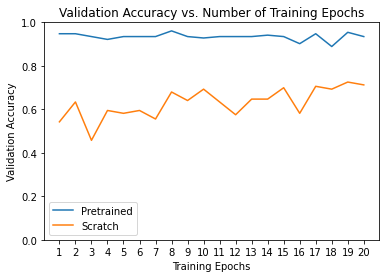

In [94]:
plt.title('Validation Accuracy vs. Number of Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Validation Accuracy')
# val_acc_history_np = np.array(val_acc_history)
# scratch_history_np = np.array(scratch_history)
plt.plot(range(1, num_epochs + 1), val_acc_history, label='Pretrained')
plt.plot(range(1, num_epochs + 1), scratch_history, label='Scratch')
plt.ylim((0, 1.))
plt.xticks(np.arange(1, num_epochs + 1, 1.0))
plt.legend()
plt.show()